# Crew Recommendation Model

The objective of this notebook is build a Machine Learning model to predict the crew size during the design process of a ship

## Importing the libraries

In [574]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor


from IPython.display import display

%matplotlib inline
sns.set_style('whitegrid')

## Reading the dataset from the CSV file

In [3]:
ships = pd.read_csv('Barcos.csv')

## Exploratory Data Analysis (EDA)

### Structure and overall information of the dataset

In [4]:
ships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Nombre de la Embarcacion  158 non-null    object 
 1   Naviera                   158 non-null    object 
 2   Edad                      158 non-null    int64  
 3   Tonelaje                  158 non-null    float64
 4   Pasajeros                 158 non-null    float64
 5   Longitud                  158 non-null    float64
 6   Camarotes                 158 non-null    float64
 7   Densidad de Pasajeros     158 non-null    float64
 8   Tripulacion               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


The dataset has 9 columns and 158 rows with 0 null values. two of the columns are object, one int and the reset of them are float

In [5]:
ships.head()

,Nombre de la Embarcacion,Naviera,Edad,Tonelaje,Pasajeros,Longitud,Camarotes,Densidad de Pasajeros,Tripulacion
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


From this subset is clear that:
 - columns "Nombre de la Embarcacion" and "Naviera" are categorical variables 
 - "Edad", "Tonelaje", "Pasajeros", "Longitud", "Camarotes" and "Densidad de Pasajeros" are numerical variables
 - "Tripulacion" which is the dependant variable  is also numeric

### Analyzing categorical variables

#### Ship name

In [6]:
ship_name_counts = ships['Nombre de la Embarcacion'].value_counts()
display(ship_name_counts.to_frame())
(
    ship_name_counts
    .value_counts()
    .sort_values(ascending=True)
    .rename_axis('Ships With Same Name')
    .reset_index(name='Counts')
)

,Nombre de la Embarcacion
Spirit,4
Legend,3
Star,3
Majesty,2
Dawn,2
...,...
Aurora,1
Cloud,1
Volendam,1
Valor,1


,Ships With Same Name,Counts
0,4,1
1,3,2
2,2,13
3,1,122


There are 138 unique names, this means that some names can be repeated but not in a rate that can represent an estimator

In [7]:
ships[ships['Nombre de la Embarcacion'] == 'Spirit']

,Nombre de la Embarcacion,Naviera,Edad,Tonelaje,Pasajeros,Longitud,Camarotes,Densidad de Pasajeros,Tripulacion
20,Spirit,Carnival,12,88.500,21.24,9.63,10.56,41.67,10.29
83,Spirit,Norwegian,15,75.338,19.56,8.79,9.83,38.52,13.00
144,Spirit,Seabourn,24,10.000,2.08,4.40,1.04,48.08,1.60
155,Spirit,Windstar,25,5.350,1.58,4.40,0.74,33.86,0.88


for example the most popular name is "Spirit" but the caracteristics of the ships are totally different

#### Company

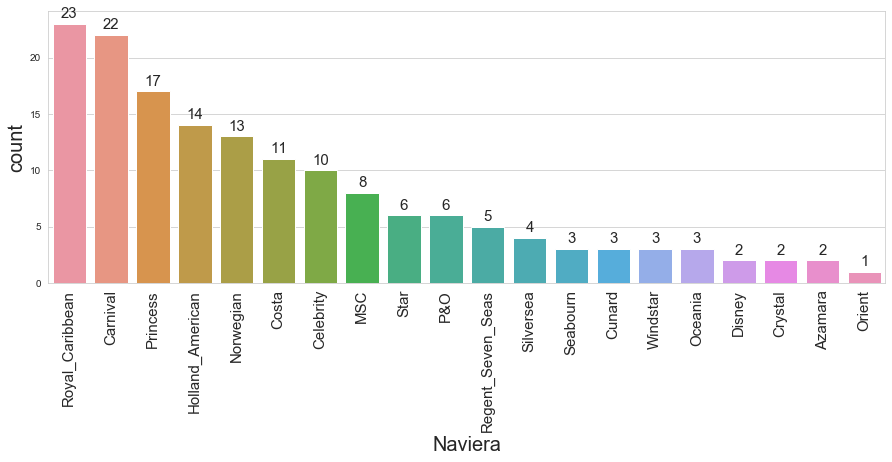

In [8]:
naviera_counts = ships['Naviera'].value_counts()

plt.figure(figsize=(15, 5))
graph = sns.countplot(x='Naviera', data=ships, order=naviera_counts.index)
graph.xaxis.set_tick_params(rotation=90, labelsize=15)
graph.xaxis.get_label().set_fontsize(20)
graph.yaxis.get_label().set_fontsize(20)
for p in graph.patches:
    graph.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha = 'center',
        va = 'center',
        xytext = (0, 10),
        textcoords = 'offset points',
        size=15
    )

From this instance is observed that there are 20 different companies, the biggest is Royal_Caribbean with 23 ships and the smallest is Orient with 1

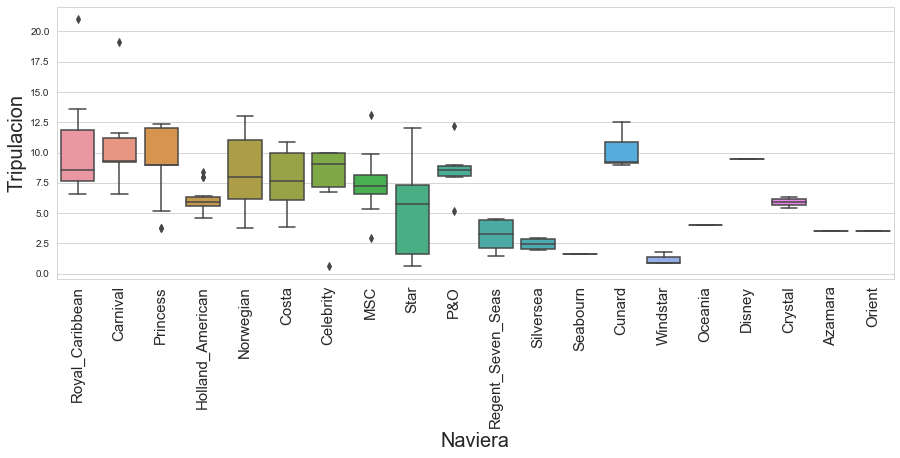

In [9]:
plt.figure(figsize=(15, 5))
graph = sns.boxplot(
    x='Naviera',
    y='Tripulacion',
    data=ships,
    order=naviera_counts.index)
graph.xaxis.set_tick_params(rotation=90, labelsize=15)
graph.xaxis.get_label().set_fontsize(20)
graph.yaxis.get_label().set_fontsize(20)


From the box plot is difficult to see a clear relationship between the company and the crew number, eventhough in some cases like Holland_American seems to have the crew of their ships in the same range. Nevertheless, there are companies with very few ships so including this variable could lead us to overfit our model and besides the model would perform poorly to predict data for a non included company 

### Analizing numerical variables

In [10]:
ships.describe()

,Edad,Tonelaje,Pasajeros,Longitud,Camarotes,Densidad de Pasajeros,Tripulacion
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


There are two important observations from this table
 - First, the data has different scale of values, for example, the maximum value of Tonnage is 220 while the max value of Longitud is 11.82.
 - Second, crew has a mean of 7.79 with a std of 3.5 and a value in 75 percentile of 9.9. However, its max value is 21 which can lead to think in outliers

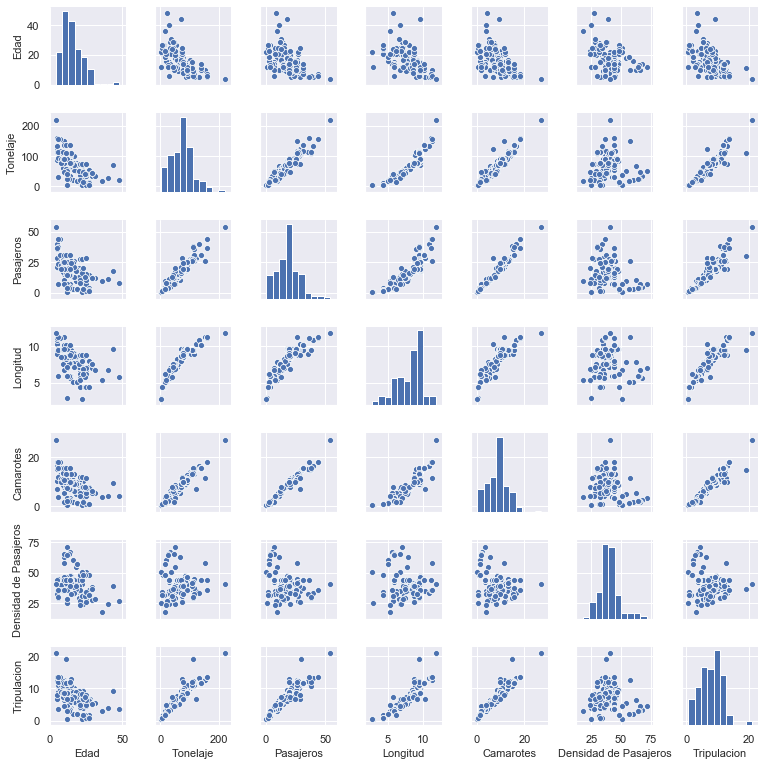

In [11]:
sns.set(rc={'axes.labelsize':'11'})
graph = sns.pairplot(ships, height=1.5)

These sort of graphs reveal a lot of information.
 - variables age and passanger density seem to be bad predictors for crew. In the other hand, tonnage, passangers, lenght and cabins have significant correlation .
 - two observations have unusual crew values
 - the relationship between the variables tonnage, passangers, lenght and cabins show a possible multicollinearity

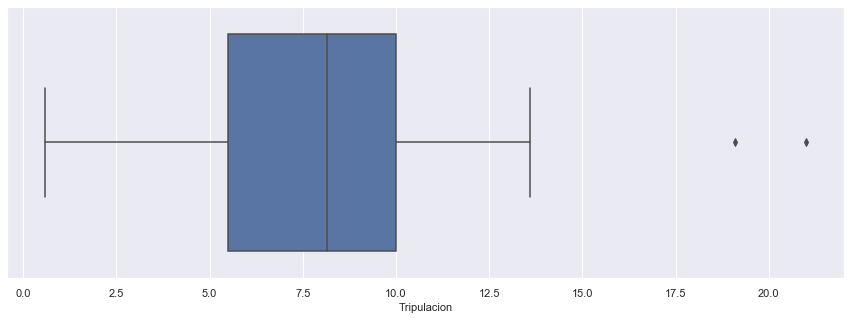

In [12]:
plt.figure(figsize=(15, 5))
sns.boxplot(ships['Tripulacion'])
plt.show()

Given that two observations have unusually high crew values they are considered as outliers and therefor remmoved from the dataset 

In [13]:
ships_cleaned = ships[ships['Tripulacion'] < 18]

In [14]:
#ships_cleaned['Longitud2'] = np.sqrt(np.max(ships_cleaned['Longitud'] + 1) - ships_cleaned['Longitud'])

In [15]:
# fig, ax = plt.subplots(1,3, figsize=(15,5))
# sns.distplot(ships_cleaned['Longitud'], ax=ax[0])
# sns.distplot(ships_cleaned['Longitud2'], ax=ax[1])

## Setting a baseline

In [32]:
mean_crew_value = ships_cleaned['Tripulacion'].mean()
print('The crew mean is: ', mean_crew_value)

The crew mean is:  7.637051282051282


In order to have a comparison to know if a model is good or not a baseline is set using the mean of the crew values. This value will be used as predicted value for each one of the observations and therefor as reference against the predictions of the model.

## Variable selection

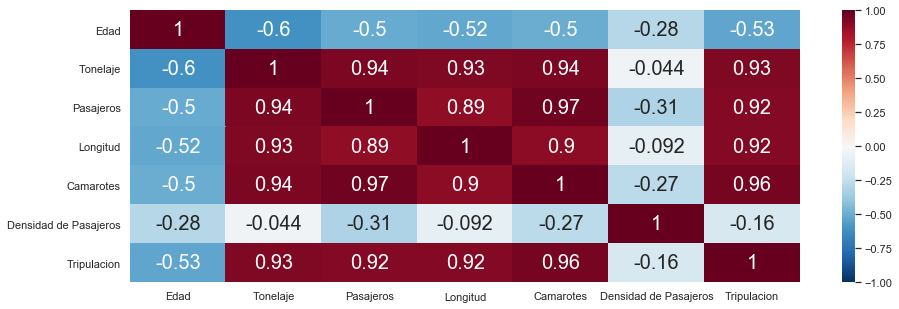

In [18]:
plt.figure(figsize=(15, 5))
graph = sns.heatmap(
    ships_cleaned.corr(),
    annot=True,
    cmap='RdBu_r',
    vmin=-1,
    vmax=1,
    annot_kws={'size': 20}
)

The correlation graph shows that cabins is the most high correlated variable with **crew** but **tonnage**, **passangers**, **lenght** are good predictors too.

Another point to keep in mind is that these variables are correlated amonng them too

## Multiple Linear regression model

### Dividing the dataset into training and test

In [668]:
def scale_and_split_data(
        df, sel_cols, target_var='Tripulacion', 
        test_size=0.4, random_state=101, scale_flag: bool=True):
    '''Scale the data using standard scaler
        
    Args: 
        df: data frame with the information
        sel_cols: List of selected independant variables
        test_size: Float of the desired test size proportion in percentage
        random_state: int to keep seed
            
    Returns:
        scaler: Scaler object fitted with the selected independant variables
        X_train: Data frame with the subset of features to train
        X_test: Data frame with the subset of features to test
        y_train: Series with the subset of the target variable to train
        y_test: Series with the subset of the target variable to test
        
    '''
    y = df[target_var]
    if scale_flag:
        scaler = MinMaxScaler()
        X = pd.DataFrame(scaler.fit_transform(df[sel_cols]), columns=sel_cols)
    else:
        scaler = None
        X = df[sel_cols]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size , random_state=random_state)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    return scaler, X, y, X_train, X_test, y_train, y_test

In [669]:
sel_cols = [
    'Tonelaje',
    'Pasajeros',
    'Longitud',
    'Camarotes',
]
scaler, X, y, X_train, X_test, y_train, y_test = scale_and_split_data(
    ships_cleaned, sel_cols)
display(X.describe())
print('Train_size: ', X_train.shape[0], ' Test_size:', X_test.shape[0])

,Tonelaje,Pasajeros,Longitud,Camarotes
count,156.000000,156.000000,156.000000,156.000000
mean,0.429719,0.406534,0.622276,0.467755
std,0.224245,0.215205,0.208284,0.236897
min,0.000000,0.000000,0.000000,0.000000
25%,0.275390,0.273002,0.503810,0.320768
50%,0.432277,0.437732,0.675264,0.510930
75%,0.556608,0.550418,0.787808,0.578195
max,1.000000,1.000000,1.000000,1.000000


Train_size:  93  Test_size: 63


The train set has 93 observations and the test set has 63. In addition, all the variables are now in a range between 0 and 1. 

### Fit and summary of the model

In [670]:
regr = sm.OLS(y_train, sm.add_constant(X_train)).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Tripulacion   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     453.3
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           8.18e-58
Time:                        14:51:22   Log-Likelihood:                -95.769
No. Observations:                  93   AIC:                             201.5
Df Residuals:                      88   BIC:                             214.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5507      0.273      2.016      0.047       0.008       1.094
Tonelaje       3.1413      1.167      2.692      0.009       0.822       5.461
Pasajeros     -4.9169      1.964     -2.504      0.014      -8.819      -1.015
Longitud       3.7347      0.955      3.910      0.000       1.836       5.633
Camarotes     11.4659      1.876      6.113      0.000       7.738      15.194
==============================================================================
Omnibus:                        1.910   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.449
Skew:                          -0.095   Prob(JB):                        0.485
Kurtosis:                       2.419   Cond. No.                         50.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the model summary is important to focus on the following points:
- The model has a $R^2$ of 0.954 which is good and the $adjR^2$ of 0.952 is very similar
- All the variables are significant for the model given that all of them have a p_value below 0.05
- The most significant coefficient is cabins

### Testing of assumptions

In [671]:
y_train_pred = regr.predict(sm.add_constant(X_train))
y_test_pred = regr.predict(sm.add_constant(X_test))

#### Linearity of the model

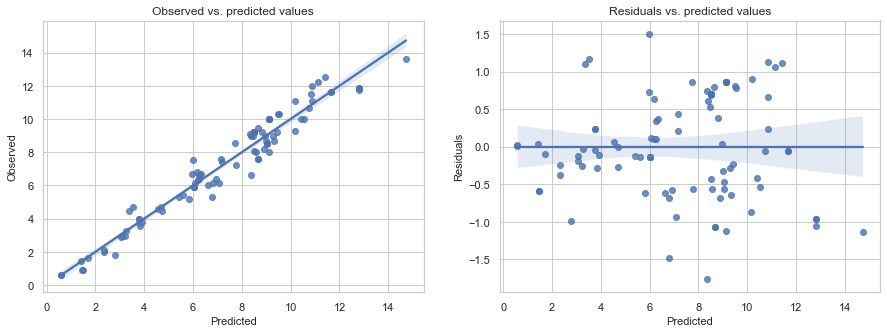

In [672]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.regplot(x=y_train_pred, y=y_train, ax=ax[0])
ax[0].set_title('Observed vs. predicted values')
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=y_train_pred, y=regr.resid, ax=ax[1])
ax[1].set_title('Residuals vs. predicted values')
ax[1].set(xlabel='Predicted', ylabel='Residuals')

plt.show()

The outcomes of the Observed vs. predicted values are symmetrically distributed around the diagonal and is the same for the Residuals vs. Predicted values against the horizontal line. In addition, both graphs shows a constant variance.
This means that there is indeed a linear relationship among variables.

#### Mean of residuals equal to zero

In [673]:
regr.resid.mean()

2.2443218132207465e-15

The mean of the residuals is indeed very close to zero meaning that a linear regression is a good fit.

#### Multivariate normal

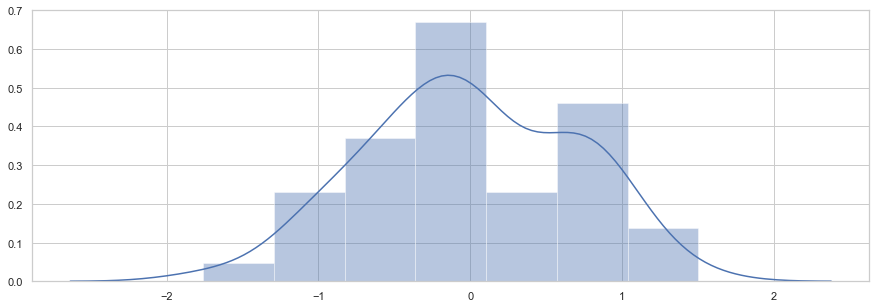

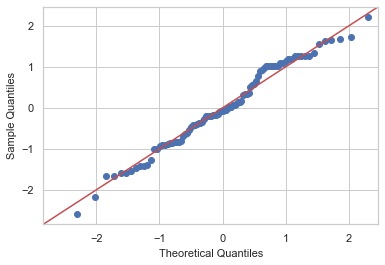

In [674]:
plt.figure(figsize=(15, 5))
sns.distplot((y_train - y_train_pred))
qqplot((y_train - y_train_pred), line='45', fit='True')
plt.show()

Residuals seems close to normality, which menas that a linear model is a good choice

#### Multicollinearity 

In [675]:
def calculate_vif(df):
    '''Calculates the variance inflation factor(VIF) and represent it as a data frame
        
    Args: 
        df: pandas data frame with the independant variables
            
    Returns:
        data frame: variables as index with the VIF value as column
    '''
    return pd.DataFrame(
        [variance_inflation_factor(df.values, i) for i in range(df.shape[1])],
        index= df.columns,
        columns=['VIF']
    )

In [676]:
calculate_vif(ships_cleaned[sel_cols])

,VIF
Tonelaje,51.741901
Pasajeros,104.083364
Longitud,14.729180
Camarotes,119.972761


 All of the variables have a VIF value above 10 which means a high multicollinearity, this prevents the coeficients to have a meaningful value by their own but the model can still be a good predictor which is the main goal

#### Residuals independance

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


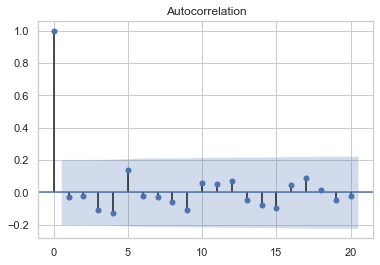

In [677]:
acf = smt.graphics.plot_acf(regr.resid)
acf.show()

None of the points are outside of critical area which means that no autocorrelation is present

### Model evaluation

In [678]:
def calculate_evaluation_metrics(y_values, predicted_values):
    '''Calculates de R^2 and RSME for a set of predicted values
    
    Args: 
        y_values (pandas.Series or list): reference values
        predicted_values: series or list of predicted values
            
    Returns:
        result_dict (dict): 
            R^2: R^2 calculation
            RMSE: RMSE calculation
    '''
    result_dict = {
        'R^2': metrics.r2_score(y_values, predicted_values),
        'RSME': np.sqrt(metrics.mean_squared_error(y_values, predicted_values ))
    }
    return result_dict

def eval_metrics_to_frame(eval_dict, name, append_to_index=''):
    '''Format the result of the evaluation metrics to pandas dataframe
    
    Args:
        eval_dict (dict): dictionary with metrics as keys and magnitude as value
            R^2: R^2 calculation
            RMSE: RMSE calculation
        name (str): expected column name.
        append_to_index (str): string to append to matrics names.
        
    Returns:
        (pandas.DataFrame): metrics name as index with one column that is
            equeal to name input. 
            
    '''
    return (
        pd.Series(eval_dict)
        .rename(name)
        .rename(lambda x: x + append_to_index)
    ).to_frame()
    

In [679]:
lm_metrics_df = pd.concat([
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(y_train, y_train_pred),
            name='Linear_Model',
            append_to_index='_Train'),
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(y_test, y_test_pred),
            name='Linear_Model',
            append_to_index='_Test')])
    
bl_metrics_df = pd.concat([
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(
                y_train, np.repeat(mean_crew_value, len(y_train))),
            name='BaseLine',
            append_to_index='_Train'),
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(
                y_test, np.repeat(mean_crew_value, len(y_test))),
            name='BaseLine',
            append_to_index='_Test')])

pd.concat([lm_metrics_df, bl_metrics_df], axis=1)

,Linear_Model,BaseLine
R^2_Train,0.953714,-0.015960
RSME_Train,0.677624,3.174702
R^2_Test,0.918810,-0.032837
RSME_Test,0.923625,3.294282


The linear model performs significantly better in both training and test with a reduction in RSME of 79% in train and 72% in test

#### Cross validation

In [680]:
def cv_eval_metrics(X, y, model, n_splits=10, test_size=0.4, random_state=23):
    n_samples = X.shape[0]
    cv = ShuffleSplit(
        n_splits=n_splits, test_size=test_size, random_state=random_state)
    scores = cross_validate(
        model, X, y, cv=cv,
        scoring=['r2', 'neg_root_mean_squared_error'], return_train_score=True)

    mean_results = lambda x: np.round(np.mean(x), 3)
    sd_results = lambda x: np.round(np.std(x), 3)

    res_df = pd.DataFrame(
        {
            'R^2_mean': [
                mean_results(scores['train_r2']),
                mean_results(scores['test_r2'])],
            'R^2_Std':  [
                sd_results(scores['train_r2']),
                sd_results(scores['test_r2'])],
            'RSME_mean': [
                mean_results(scores['train_neg_root_mean_squared_error']*-1),
                mean_results(scores['test_neg_root_mean_squared_error']*-1)],
            'RSME_Std':[
                sd_results(scores['train_neg_root_mean_squared_error']*-1),
                sd_results(scores['test_neg_root_mean_squared_error']*-1)],
        },
        index=['Train', 'Test']
    )
    return res_df

In [681]:
lm = LinearRegression()
lm_cv_metr = cv_eval_metrics(
    X, y, lm, n_splits=10, test_size=0.4, random_state=0)
print('Multiple Linear Regression Model')
lm_cv_metr

Multiple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.944,0.012,0.748,0.089
Test,0.933,0.019,0.838,0.127


After 10 iterations of random samples the model peforms well on both training and test, the accuracy is a little bit lower in test but the standard deviation can be considered low in both

## Simple Linear Model

In case that interpretability of residuals is required, a simple linear model would be the best choice, given the high multicollinearity of the variables

### Split data into training and test

In [682]:
sel_cols = ['Camarotes']
scaler, X, y, X_train, X_test, y_train, y_test = scale_and_split_data(
    ships_cleaned, sel_cols, scale_flag=False)
display(X.describe())
print('Train_size: ', X_train.shape[0], ' Test_size:', X_test.shape[0])

,Camarotes
count,156.000000
mean,8.674744
std,4.226246
min,0.330000
25%,6.052500
50%,9.445000
75%,10.645000
max,18.170000


Train_size:  93  Test_size: 63


The train set has 93 observations and the test set has 63. In addition, all the variables are now in a range between 0 and 1. 

### Summary

In [683]:
s_regr = sm.OLS(y_train, sm.add_constant(X_train)).fit()
s_regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Tripulacion   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1108.
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           9.80e-53
Time:                        14:51:43   Log-Likelihood:                -118.77
No. Observations:                  93   AIC:                             241.5
Df Residuals:                      91   BIC:                             246.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2749      0.201      6.344      0.000       0.876       1.674
Camarotes      0.7295      0.022     33.284      0.000       0.686       0.773
==============================================================================
Omnibus:                        7.170   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.606
Skew:                           0.589   Prob(JB):                       0.0368
Kurtosis:                       3.563   Cond. No.                         20.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model summary shows that 0.924 of the variance of the data is reprsented by cabins and for each unit increase in cabins, crew will increse 0.729

### Testing of assumptions

In [684]:
y_train_pred = s_regr.predict(sm.add_constant(X_train))
y_test_pred = s_regr.predict(sm.add_constant(X_test))

#### Linearity of the model

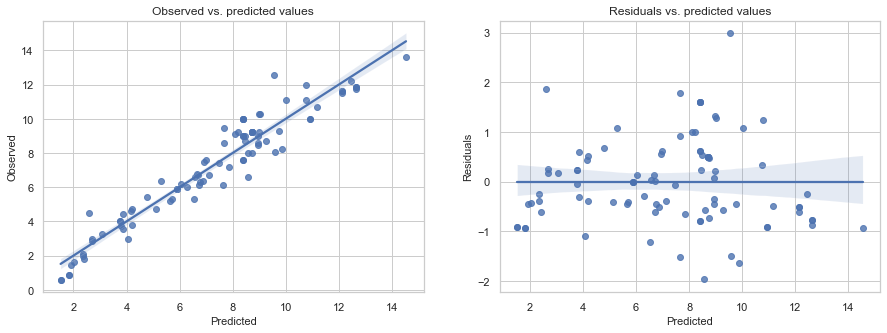

In [685]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.regplot(x=y_train_pred, y=y_train, ax=ax[0])
ax[0].set_title('Observed vs. predicted values')
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=y_train_pred, y=s_regr.resid, ax=ax[1])
ax[1].set_title('Residuals vs. predicted values')
ax[1].set(xlabel='Predicted', ylabel='Residuals')

plt.show()

Both graphs shows constant variance and symmetrical distributed points which represent linear relationship among variables.

#### Mean of residuals equal to zero

In [686]:
s_regr.resid.mean()

2.750488009393936e-15

The mean of the residuals is indeed very close to zero meaning that a linear regression is a good fit.

#### Multivariate normal

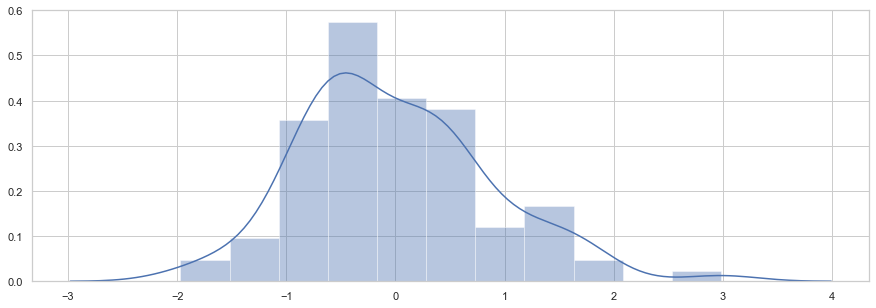

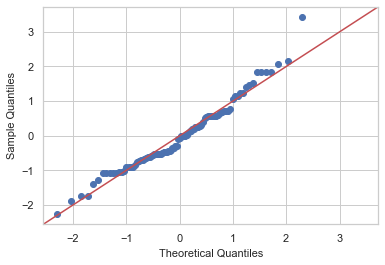

In [687]:
plt.figure(figsize=(15, 5))
sns.distplot((y_train - y_train_pred))
qqplot((y_train - y_train_pred), line='45', fit='True')
plt.show()

Residuals seems close to normality, however in the right tail an outlier is identified.

#### Residuals independance

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


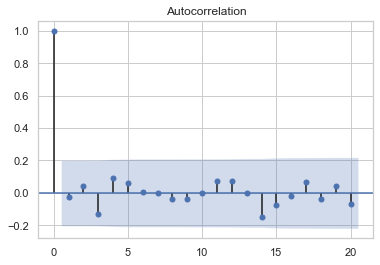

In [688]:
acf = smt.graphics.plot_acf(s_regr.resid)
acf.show()

None of the points are outside of critical area which means that no autocorrelation is present

### Model evaluation

In [689]:
slm_metrics_df = pd.concat([
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(y_train, y_train_pred),
            name='Simple_Linear_Model',
            append_to_index='_Train'),
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(y_test, y_test_pred),
            name='Simple_Linear_Model',
            append_to_index='_Test')])

pd.concat([lm_metrics_df, slm_metrics_df], axis=1)

,Linear_Model,Simple_Linear_Model
R^2_Train,0.953714,0.924091
RSME_Train,0.677624,0.867781
R^2_Test,0.918810,0.897326
RSME_Test,0.923625,1.038664


The multiple linear model is better than the simple linear model by 22% in train, and by 11% in test.

#### Cross validation

In [690]:
s_lm = LinearRegression()
s_lm_cv_metr = cv_eval_metrics(
    X, y, s_lm, n_splits=10, test_size=0.4, random_state=0)
print('Multiple Linear Regression Model')
display(lm_cv_metr)
print('Simple Linear Regression Model')
display(s_lm_cv_metr)

Multiple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.944,0.012,0.748,0.089
Test,0.933,0.019,0.838,0.127


Simple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.917,0.013,0.915,0.08
Test,0.910,0.018,0.971,0.11


After 10 iterations of random samples, the multiple linear model performs better in terms of mean RSME in both train (18%) and test (14%). However, this difference is not significant given the standard deviation of the RSME.
Taking this into account the simple linear regression model is a good choice with more interpretability than the multiple linear regression

## PCA

Given that variables are highly correlated a technique of dimensionality reduction can be applied, expecting to have a better performance in the model, taking into account that the model will not be interpretable in terms of the original variables

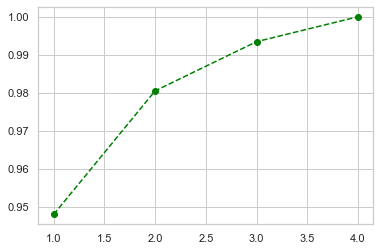

In [691]:
sel_cols = [
    'Tonelaje',
    'Pasajeros',
    'Longitud',
    'Camarotes',
]
scaler, X, y, X_train, X_test, y_train, y_test = scale_and_split_data(
    ships_cleaned, sel_cols)

pca = PCA().fit(X)

fig, ax = plt.subplots()
xi = np.arange(1, 5, step=1)
variance_csum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(xi, variance_csum, marker='o', linestyle='--', color='green')
plt.show()

More than 99% of the variability can be represented with 3 components.

## Linear model with PCA

In [692]:
# # PCA with one components (roughly 95% of variability)
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Only one component is selected given that the rest of the components resulted in not being significant for the linear model

### Summary

In [693]:
s_regr_pca = sm.OLS(y_train, sm.add_constant(X_train_pca)).fit()
s_regr_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Tripulacion   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     1524.
Date:                Wed, 24 Jun 2020   Prob (F-statistic):           1.25e-58
Time:                        14:55:25   Log-Likelihood:                -104.91
No. Observations:                  93   AIC:                             213.8
Df Residuals:                      91   BIC:                             218.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.6196      0.079     96.481      0.000       7.463       7.776
x1             7.2846      0.187     39.041      0.000       6.914       7.655
==============================================================================
Omnibus:                        1.156   Durbin-Watson:                   2.277
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                0.671
Skew:                          -0.164   Prob(JB):                        0.715
Kurtosis:                       3.257   Cond. No.                         2.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model has a slightly higher R-squared than the simple linear model built with the variable cabins that was of 0.924

### Testing of assumptions

In [694]:
y_train_pred = s_regr_pca.predict(sm.add_constant(pca.transform(X_train)))
y_test_pred = s_regr_pca.predict(sm.add_constant(pca.transform(X_test)))

#### Linearity of the model

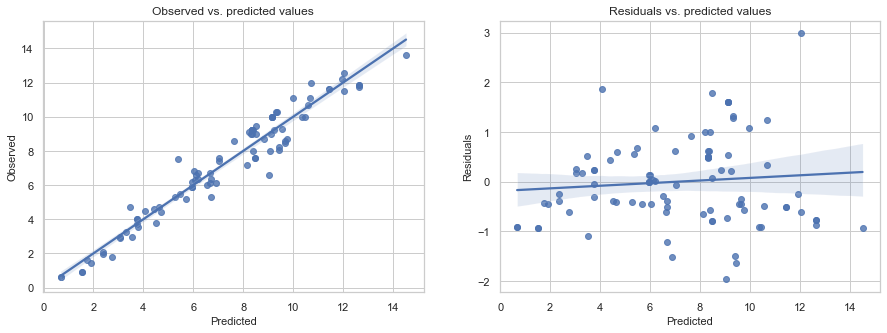

In [695]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

sns.regplot(x=y_train_pred, y=y_train, ax=ax[0])
ax[0].set_title('Observed vs. predicted values')
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=y_train_pred, y=s_regr.resid, ax=ax[1])
ax[1].set_title('Residuals vs. predicted values')
ax[1].set(xlabel='Predicted', ylabel='Residuals')

plt.show()

As expected both graphs shows constant variance and symmetrical distributed points which represent linear relationship among variables.

#### Mean of residuals equal to zero

In [696]:
s_regr_pca.resid.mean()

-3.2471038999789525e-16

The mean of the residuals is indeed very close to zero meaning that a linear regression is a good fit.

#### Multivariate normal

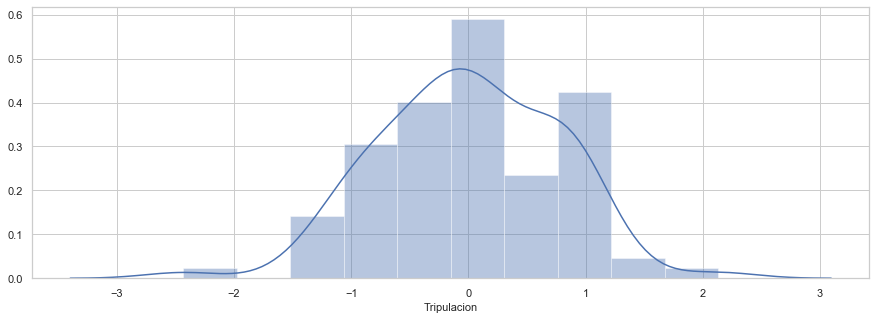

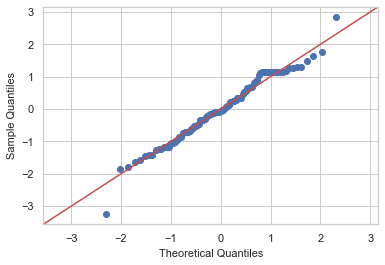

In [697]:
plt.figure(figsize=(15, 5))
sns.distplot((y_train - y_train_pred))
qqplot((y_train - y_train_pred), line='45', fit='True')
plt.show()

Residuals seems close to normality, however in both tails outliers can be identified.

#### Residuals independance

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


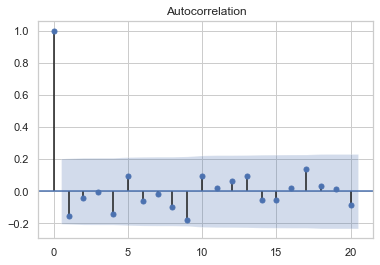

In [698]:
acf = smt.graphics.plot_acf(s_regr_pca.resid)
acf.show()

None of the points are outside of critical area which means that no autocorrelation is present

### Model evaluation

In [699]:
slm_pca_metrics_df = pd.concat([
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(y_train, y_train_pred),
            name='LM_PCA',
            append_to_index='_Train'),
        eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(y_test, y_test_pred),
            name='LM_PCA',
            append_to_index='_Test')])

pd.concat([lm_metrics_df, slm_pca_metrics_df], axis=1)

,Linear_Model,LM_PCA
R^2_Train,0.953714,0.943659
RSME_Train,0.677624,0.747613
R^2_Test,0.918810,0.881780
RSME_Test,0.923625,1.114527


The model built with pca performs slightly worst in test than the multiple linear regression model given that the RSME is 0.23 higher

#### Cross validation

In [700]:
pca_lm = LinearRegression()
pca_lm_cv_metr = cv_eval_metrics(X_pca, y, pca_lm, n_splits=10, test_size=0.4, random_state=0)
print('Multiple Linear Regression Model')
display(lm_cv_metr)
print('Simple Linear Regression Model')
display(s_lm_cv_metr)
print('PCA Linear Regression Model')
display(pca_lm_cv_metr)

Multiple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.944,0.012,0.748,0.089
Test,0.933,0.019,0.838,0.127


Simple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.917,0.013,0.915,0.08
Test,0.910,0.018,0.971,0.11


PCA Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.918,0.014,0.912,0.089
Test,0.922,0.021,0.904,0.139


There is not an important difference in the performance of the linear model using pca after cross validation

## Random Forest

### Building a Random Forest model with default values

In [701]:
# PCA with three components (more than 99% of variability)
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [702]:
# Creating a RandomForest model with default parameters to be used as baseline
rf = RandomForestRegressor(random_state = 23)
rf.fit(X_train_pca, y_train)
pd.concat([
eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(
                y_train, rf.predict(X_train_pca)),
            name='RF_Model',
            append_to_index='_Train'),
eval_metrics_to_frame(
            eval_dict=calculate_evaluation_metrics(
                y_test, rf.predict(X_test_pca)),
            name='RF_Model',
            append_to_index='_Test')])

,RF_Model
R^2_Train,0.993122
RSME_Train,0.261209
R^2_Test,0.884731
RSME_Test,1.100528


The random forest model built using the default parameters performs very well in train. Nevertheless, results in test set are not as good

In [703]:
rf_cv_metr = cv_eval_metrics(X_pca, y, rf, n_splits=10, test_size=0.4, random_state=0)
print('Multiple Linear Regression Model')
display(lm_cv_metr)
print('Simple Linear Regression Model')
display(s_lm_cv_metr)
print('PCA Linear Regression Model')
display(pca_lm_cv_metr)
print('Default RF Model')
display(rf_cv_metr)

Multiple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.944,0.012,0.748,0.089
Test,0.933,0.019,0.838,0.127


Simple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.917,0.013,0.915,0.08
Test,0.910,0.018,0.971,0.11


PCA Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.918,0.014,0.912,0.089
Test,0.922,0.021,0.904,0.139


Default RF Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.989,0.001,0.334,0.017
Test,0.940,0.011,0.795,0.079


The random forest model performs better in train and test than the previous models given that can be considered that the 5% improvement of RSME against the multiple regression model comes with a lower standard deviation too

### Random forest hyperparameter tuning

#### Random Search

In [593]:
# Build the grid of parameters to be sampled 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=600, stop=3000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1, 2, 4]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap}
random_grid

{'n_estimators': [600, 866, 1133, 1400, 1666, 1933, 2200, 2466, 2733, 3000],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [1, 2, 4],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In order to identify the best combinations of hyperparameters, a grid with a range of possible values is created

In [594]:
# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=23,
    n_jobs=-1)

rf_random.fit(X_train_pca, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


{'n_estimators': 1666,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

The range of possibilities has been reduced to around 1666 estimators, the minimum number of samples required to split a node is around 4, the minimum number of samples required to be at a leaf node is around 2, the maximum depth of the tree is set near 10, and the bootstrap samples and the number of features to consider when looking for the best split are set to default

In [596]:
rf_best_rand = rf_random.best_estimator_
rf_best_rand_cv_metr = cv_eval_metrics(
    X_pca, y, rf_best_rand, n_splits=10, test_size=0.4, random_state=0)
print('Multiple Linear Regression Model')
display(lm_cv_metr)
print('Simple Linear Regression Model')
display(s_lm_cv_metr)
print('PCA Linear Regression Model')
display(pca_lm_cv_metr)
print('Default RF Model')
display(rf_cv_metr)
print('Best Rand RF Model')
display(rf_best_rand_cv_metr)

Multiple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.944,0.012,0.748,0.089
Test,0.933,0.019,0.838,0.127


Simple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.917,0.013,0.915,0.08
Test,0.910,0.018,0.971,0.11


PCA Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.918,0.014,0.912,0.089
Test,0.922,0.021,0.904,0.139


Default RF Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.989,0.001,0.334,0.017
Test,0.940,0.011,0.795,0.079


Best Rand RF Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.979,0.002,0.456,0.023
Test,0.937,0.012,0.815,0.086


In general the behaviour of the model obtained by the randomized search has a lower performance than the default random forest model but only by 2%, this means that the performance of the model probably will not have an important impact with hyperparameter tuning.

#### Grid Search

In [704]:
# Creation of the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [8, 9, 10, 11, 12, None],
    'max_features': [2, 3, 4, 'auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [1100, 1200, 1300, 1400]
}

rf_tunning = RandomForestRegressor() 
grid_search = GridSearchCV(
    estimator = rf_tunning, param_grid = param_grid, 
    cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_pca, y_train)
grid_search.best_params_

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 37.5min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1300}

In [508]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 2700}

In [706]:
rf_best_search = grid_search.best_estimator_
rf_best_search_cv_metr = cv_eval_metrics(
    X_pca, y, rf_best_search, n_splits=10, test_size=0.4, random_state=0)
print('Multiple Linear Regression Model')
display(lm_cv_metr)
print('Simple Linear Regression Model')
display(s_lm_cv_metr)
print('PCA Linear Regression Model')
display(pca_lm_cv_metr)
print('Default RF Model')
display(rf_cv_metr)
print('Best Rand RF Model')
display(rf_best_rand_cv_metr)
print('Best Search RF Model')
display(rf_best_search_cv_metr)

Multiple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.944,0.012,0.748,0.089
Test,0.933,0.019,0.838,0.127


Simple Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.917,0.013,0.915,0.08
Test,0.910,0.018,0.971,0.11


PCA Linear Regression Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.918,0.014,0.912,0.089
Test,0.922,0.021,0.904,0.139


Default RF Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.989,0.001,0.334,0.017
Test,0.940,0.011,0.795,0.079


Best Rand RF Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.979,0.002,0.456,0.023
Test,0.937,0.012,0.815,0.086


Best Search RF Model


,R^2_mean,R^2_Std,RSME_mean,RSME_Std
Train,0.986,0.002,0.373,0.023
Test,0.940,0.012,0.792,0.083


After the process of tuning the random forest performs very similar to the default random forest model, it has a slight improvement in RSME but it is not meaningful

## Conclusion

The model with the lowest RSME and the highest $R^2$ is the one built using **Random Forest**, given that the main goal is to predict better the neccesary crew, this is the recommended model. However, if the interpretation of the variables is required, the best model is the **simple regression model**